In [0]:

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [0]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [0]:
#Utils


def simple_das3h_curve(alpha, delta, beta, thetas, n_attempts, n_wins):
    """
    Plot the evolution of the probability of correctness of a student with
    ability alpha, on an item with difficulty delta, tagged with a *single* skill
    with difficulty beta. The student has n_wins out of n_attempts on t=0, on
    this skill. thetas gathers the theta parameters from the DAS3H model: first the wins
    and then the attempts, on a single skill -- the one that we are concerned about. Thus,
    this array is of size nb_of_tw*2.
    Attention, ici les premières colonnes de windows_attempts/wins correspondent aux time windows
    les plus récentes (contrairement à la dernière version GitHub du code DAS3H).
    """
    list_of_boundaries = [0, 1/24, 1, 7, 30]
    windows_wins = np.triu(np.ones((len(list_of_boundaries),len(list_of_boundaries))))*np.log(n_wins+1)
    windows_attempts = np.triu(np.ones((len(list_of_boundaries),len(list_of_boundaries))))*np.log(n_attempts+1)
    probas = [logistic(alpha+beta+delta+np.sum(windows_wins[j]*thetas[:len(list_of_boundaries)])+ \
                       np.sum(windows_attempts[j]*thetas[len(list_of_boundaries):])) for j in range(len(list_of_boundaries))]
    list_of_boundaries.append(100)
    probas.append(probas[-1])
    plt.figure(figsize=(9,6))
    plt.step(list_of_boundaries, probas, where="post")
    plt.scatter(list_of_boundaries, probas, c="r")
    plt.xlim((0,60))
    plt.ylim((0,1))
    plt.title(r'Memory decay over time on a skill for an example student', fontsize=16)
    plt.xlabel(r'Time (in days)', fontsize=13)
    plt.ylabel(r'Correctness probability', fontsize=13)
    plt.show()


In [0]:

class OurQueue:
    """
    A queue for counting efficiently the number of events within time windows.
    Complexity:
        All operators in amortized O(W) time where W is the number of windows.

    From JJ's KTM repository: https://github.com/jilljenn/ktm.
    Modified to leave the possibility to get counters first at a t_1 and then at a t_2
    s.t. t_2 < t_1.
    
    Attention : l'ordre est inversé pour l'output. Les fenêtres temporelles les plus récentes
    sont *à la fin*.
    """
    def __init__(self):
        self.queue = []
        #self.window_lengths = [30, 7, 1, 1/24] # in days, for convenience sake
        self.window_lengths = [3600*24*30, 3600*24*7, 3600*24, 3600]
        self.cursors = [0] * len(self.window_lengths)

    def __len__(self):
        return len(self.queue)

    def get_counters(self, t):
        self.update_cursors(t)
        res = [len(self.queue)] + [len(self.queue) - cursor
                                    for cursor in self.cursors]
        return res[::-1]

    def push(self, time):
        self.queue.append(time)

    def update_cursors(self, t):
        self.cursors = [0] * len(self.window_lengths) # reset cursors
        for pos, length in enumerate(self.window_lengths):
            while (self.cursors[pos] < len(self.queue) and
                   t - self.queue[self.cursors[pos]] >= length):
                self.cursors[pos] += 1



In [0]:
def complex_das3h_curve(alpha, delta, beta, thetas, dico_of_events):
    """
    ex format of each value in dico_of_events: (n_wins, n_attempts)
    keys = timestamps. Thus, the keys need to be all different.
    
    Warning: here, the order of the time window features is reversed,
    first the oldest tw, and then the youngest.
    """
    list_of_boundaries = [0, 3600, 3600*24, 3600*24*7, 3600*24*30]
    q = defaultdict(lambda: OurQueue())
    list_of_timestamps = set()
    for event in dico_of_events:
        for boundary in list_of_boundaries:
            list_of_timestamps.add(event+boundary)
    list_of_timestamps = list(list_of_timestamps)
    list_of_timestamps.sort()
    probas = []
    for event in list_of_timestamps:
        if event in dico_of_events.keys():
            for i in range(dico_of_events[event][1]):
                q["attempts"].push(event)
            for i in range(dico_of_events[event][0]):
                q["wins"].push(event)
        attempts = np.array(q["attempts"].get_counters(event))
        wins = np.array(q["wins"].get_counters(event))
        probas.append(logistic(alpha+beta+delta+np.sum(np.log(wins+1)*thetas[:len(list_of_boundaries)])+ \
                               np.sum(np.log(attempts+1)*thetas[len(list_of_boundaries):])))
    timestamps_in_sec = [t/(3600*24) for t in list_of_timestamps]
    timestamps_in_sec.append(20+timestamps_in_sec[-1])
    probas.append(probas[-1])
    plt.figure(figsize=(9,6))
    plt.step(timestamps_in_sec, probas, where="post")
    plt.scatter(timestamps_in_sec, probas, c="r")
    plt.xlim((0,timestamps_in_sec[-1]))
    plt.ylim((0,1))
    plt.title(r'Memory decay over time on a skill for an example student', fontsize=16)
    plt.xlabel(r'Time (in days)', fontsize=13)
    plt.ylabel(r'Correctness probability', fontsize=13)
    plt.show()    


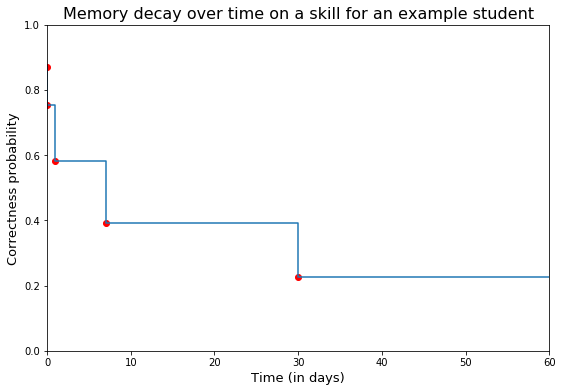

In [14]:
# Exemple simple learning/forgetting curve
simple_das3h_curve(0,-1,-1,np.ones(10)*.2, 6, 6)

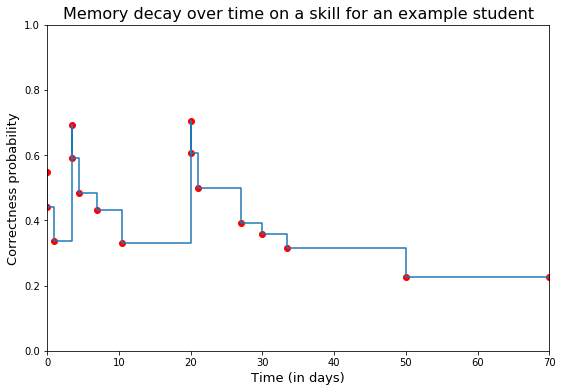

In [15]:
# Exemple more complex learning/forgetting curve
complex_das3h_curve(0,-1,-1,np.array([.2]*10),{0:(2,2),3.5*3600*24:(2,2),20*3600*24:(2,2)})